In [91]:
import os
from collections import Counter

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn_crfsuite import metrics
from src.articles_extraction import ArticlesExtraction
from src.sequence_tagger import CRFSequenceClassifier
from src.terms_extraction import RuleBasedExtractor
from src.texts_annotation import Annotator, TerminologyTree, fill_terminology_tree

## Articles extraction

In [2]:
artextr = ArticlesExtraction(30, save_txt=False, save_pdf=False)
articles = artextr.extract()
texts = [x for x in list(articles.values())]


Getting the links for 30 articles...
Getting the texts...


In [3]:
train = texts[:20]  # 20 articles for training
test = texts[20:]  # 10 articles for testing

## Rule-based terms extraction

In [4]:
r = RuleBasedExtractor()
all_terms = r.extract(train)


In [5]:
print(f'Number of extracted terms: {len(all_terms)}')

Number of extracted terms: 23977


In [6]:
print('10 first extracted terms')
for num, term in enumerate(all_terms[:10]):
    print(num + 1, term)


10 first extracted terms
1 tropical forest
2 mature tropical forest
3 many mature tropical forest
4 ecological significance
5 p stock
6 stock as soil
7 soil age
8 tropical forest
9 forest soil
10 various form


Saving 200 the most popular terms in 'data/auto_popular_terms.txt'

In [95]:
if not os.path.exists('data/'):
    os.mkdir('data')

popular_terms = Counter([x.lower() for x in all_terms]).most_common(200)
with open('data/auto_popular_terms.txt', 'w', encoding='utf-8') as autoterms:
    for term in popular_terms:
        autoterms.write(term[0] + '\n')


Filtered terms extraction

In [8]:
with open('data/manual_popular_terms.txt', encoding='utf-8') as terms:
    terms = terms.read().split('\n')

In [9]:
print(f'Number of terms before manual filtering: {len(popular_terms)}')
print(f'Number of terms after manual filtering: {len(terms)}')


Number of terms before manual filtering: 200
Number of terms after manual filtering: 174


## Datasets annotation

In [10]:
anno = Annotator()
tree = TerminologyTree()
terminology = [t.split(' ') for t in terms]
fill_terminology_tree(terminology, tree)
annotated_train = [anno.annotate(tree, text) for text in train]
annotated_test = [anno.annotate(tree, text) for text in test]

## Tagging with supervised learning algorithm

CRF sequence classifier training

In [70]:
seq = CRFSequenceClassifier()
X_train, y_train = seq.convert_corpus(annotated_train)
model = seq.fit(X_train, y_train)
labels = list(model.classes_)

CRF sequence classifier training


Computing model's predictions

In [93]:
X_test, y_test = seq.convert_corpus(annotated_test)
y_pred = model.predict(X_test)
score = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
print(f'F1-score weighted: {score}')

F1-score weighted: 0.9935069333322301


In [31]:
flat_y_test = sum(y_test)
flat_y_pred = sum(y_pred)

Classification report

In [94]:
class_report = classification_report(y_true=flat_y_test, y_pred=flat_y_pred, labels=labels)
print(class_report)

Classification report
              precision    recall  f1-score   support

           O       1.00      1.00      1.00     67972
           B       0.85      0.38      0.52       266
           I       0.85      0.37      0.52       276

    accuracy                           0.99     68514
   macro avg       0.90      0.58      0.68     68514
weighted avg       0.99      0.99      0.99     68514



Confusion matrix

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

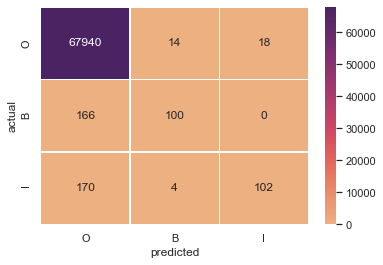

In [33]:
conf_mat = confusion_matrix(flat_y_test, flat_y_pred, labels=labels)
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels,
                     yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')